In [46]:
import numpy as np
from builtins import range
import math
import datetime
import librosa
import matplotlib.pyplot as plt

In [47]:
def spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = None, eps = 1e-14):
    max_freq = max_freq if max_freq else sample_rate // 2
    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    # print(freqs, freqs.shape)
    # Compute spectrogram feature
    # print(np.arange(fft.shape[0]))
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    # specgram = np.log(fft[:ind, :] + eps)
    specgram = fft[:ind, :]
    return specgram

In [48]:
def myconverter(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, datetime.datetime):
        return obj.__str__()
    return obj

def plot_spectrogram(samples, sampling_rate):
    plt.specgram(samples,Fs=sampling_rate)
    plt.xlabel('Time')
    plt.xlim(time_low, time_high)
    plt.ylabel('Frequency')
    plt.show()

In [105]:
import requests
req = requests.get("http://localhost:8000/api/general/songs/?get_file_path=1&title=everything_before_drum_loop")
file_path = '../' + req.text[1:-1]
file_path

'../media/uploads/songs/everything_before_drum_loop.wav'

7.495020833333333
7.47
49


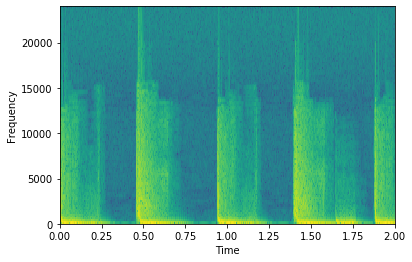

{'maxVal': 0.0062213314687401735,
 'maxFreq': 49,
 'timeStep': 0.01,
 'windows': [{'time': 0.0,
   'freqs': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
   'strengths': [171.0,
    526.0,
    1140.0,
    1241.0,
    656.0,
    333.0,
    345.0,
    532.0,
    391.0,
    155.0],
   'maxStrength': 1241.0},
  {'time': 0.01,
   'freqs': [2, 3, 4, 5, 6],
   'strengths': [1053.0, 6461.0, 3281.0, 494.0, 295.0],
   'maxStrength': 6461.0},
  {'time': 0.02,
   'freqs': [1, 2, 3, 4, 5],
   'strengths': [720.0, 7331.0, 6720.0, 367.0, 127.0],
   'maxStrength': 7331.0},
  {'time': 0.03,
   'freqs': [1, 2, 3],
   'strengths': [1385.0, 6740.0, 1822.0],
   'maxStrength': 6740.0},
  {'time': 0.04,
   'freqs': [1, 2, 3, 4],
   'strengths': [2545.0, 4284.0, 510.0, 105.0],
   'maxStrength': 4284.0},
  {'time': 0.05,
   'freqs': [0, 1, 2, 3],
   'strengths': [503.0, 5720.0, 5241.0, 300.0],
   'maxStrength': 5720.0},
  {'time': 0.06,
   'freqs': [0, 1, 2, 3],
   'strengths': [1221.0, 9051.0, 6990.0, 134.0],
   'maxStr

In [116]:
samples, sampling_rate = librosa.load(file_path, sr=None, mono=True, offset=0.0, duration=None)
window_ms = 20
stride_ms = 10
time_step = stride_ms/1000
window_size = window_ms * sampling_rate * 0.001
s = spectrogram(samples, sampling_rate, window_ms=window_ms, stride_ms=stride_ms)
print(len(samples)/sampling_rate)
duration = len(samples)/sampling_rate
ret = {}
max_val = np.max(s)
ret['maxVal'] = myconverter(max_val)
ret['maxFreq'] = 0
ret['timeStep'] = myconverter(time_step)
ret['windows'] = []
minimum = 5
minimum = 10 * 10**-3
time_low = 0
time_high = 2
time_dex_lower = int(time_low / time_step)
time_dex = int(time_high / time_step)
time_dex = s.shape[1]
max_time = (time_dex-1) * ((time_step * 100)//1)/100
ret['maxTime'] = max_time
for i in range(time_dex_lower, time_dex):
    time = i * ((time_step * 100)//1)/100
    cur_dict = {}
    cur_dict['time'] = myconverter(time)
    cur_values = s[:, i]
    # strength_diff = 10 - np.log(max_val/cur_values)
    strength_diff = cur_values/max_val
    max_strength = 0
    freqs = np.where(strength_diff >= minimum)[0]
    cur_dict['freqs'] = myconverter(freqs)
    cur_dict['strengths'] = []
    if len(freqs) > 0:
        max_freq = np.max(freqs)
        ret['maxFreq'] = max_freq if max_freq > ret['maxFreq'] else ret['maxFreq']
        vals = strength_diff[strength_diff >= minimum]
        vals = (vals * 10000)//1
        max_strength = np.max(vals)
        cur_dict['strengths'] = myconverter(vals)
    cur_dict['maxStrength'] = myconverter(max_strength)
    ret['windows'].append(cur_dict)
ret['maxFreq'] = myconverter(ret['maxFreq'])
plot_spectrogram(samples, sampling_rate)
ret